In [2]:
# 多 GPU 训练从零开始实现
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [3]:
# 简单网络
scale = 0.01
w1 = torch.randn(size = (20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
w2 = torch.randn(size = (50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
w3 = torch.randn(size = (800, 128)) * scale
b3 = torch.zeros(128)
w4 = torch.randn(size = (128, 10)) * scale
b4 = torch.zeros(10)
params = [w1, b1, w2, b2, w3, b3, w4, b4]

In [6]:
# 定义模型
#@save
def lenet(x, params):  
    h1_conv = F.conv2d(
        input = x, weight = params[0], 
        bias = params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(
        input = h1_activation, 
        kernel_size = (2, 2), stride = (2, 2))
    h2_conv = F.conv2d(
        input = h1, weight = params[2], 
        bias = params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(
        input = h2_activation, 
        kernel_size = (2, 2), stride = (2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(
        h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

In [7]:
# 交叉熵损失
loss = nn.CrossEntropyLoss(reduction = 'none')

In [8]:
# 数据同步
#@save
def get_params(params, device):
    new_params = [
        p.clone().to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

In [9]:
new_params = get_params(params, d2l.try_gpu(0))
print("b1 weight:", new_params[1])
print("b1 weight:", new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 weight: None


In [10]:
#@save
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i] = data[0].to(data[i].device)

In [13]:
data = [
    torch.ones((1, 2), 
               device = d2l.try_gpu(i)) * (
        i + 1) for i in range(2)]

In [14]:
len(data)

2

In [15]:
print(
    "before allreduce:\n", data[0], '\n', data[1])

before allreduce:
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]])


In [16]:
allreduce(data)
print(
    "after allreduce:\n", data[0], '\n', data[1])

after allreduce:
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]])


In [19]:
# 因为只有一个 GPU, 所以第一组数据放进了 CPU 
data[1].device

device(type='cpu')

In [30]:
# 数据分发
data = torch.arange(20).reshape(4, 5)
devices = [
    torch.device('cuda:0'), 
    torch.device('cuda:0')]
split = nn.parallel.scatter(data, devices)
print('input:', data)
print('load into:', devices)
print('output:', split)

input: tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into: [device(type='cuda', index=0), device(type='cuda', index=0)]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:0'))


In [31]:
def split_batch(x, y, devices):
    assert x.shape[0] == y.shape[0]
    return (
        nn.parallel.scatter(x, devices), 
        nn.parallel.scatter(y, devices))

In [10]:
from torch.utils import data
import torchvision
from torchvision import transforms
def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4
def load_data_fashion_mnist(batch_size, resize = None):  #@save
    """下载 Fashion-mnist 数据集，然后加载到数据内存中"""
    """
    transforms.ToTensor:
    Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor
    """
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root = '~', 
                                                    train = True, transform = trans, download = True)
    mnist_test = torchvision.datasets.FashionMNIST(root = '~', 
                                                    train = False, transform = trans, download = True)
    return (data.DataLoader(mnist_train, batch_size, shuffle = True, num_workers = get_dataloader_workers()), 
            data.DataLoader(mnist_test, batch_size, shuffle = False, num_workers = get_dataloader_workers()))

In [44]:
# 训练
def train_batch(
    x, y, device_params, devices, lr):
    x_shards, y_shards = split_batch(
        x, y, devices)
    ls = [
        loss(lenet(x_shard, device_w), y_shard).sum() 
        for x_shard, y_shard, device_w in zip(
            x_shards, y_shards, device_params)]
    for l in ls:
        l.backward()
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce(
                [device_params[c][i].grad 
                 for c in range(len(devices))])
    for param in device_params:
        d2l.sgd(param, lr, x.shape[0])

In [49]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = load_data_fashion_mnist(
        batch_size)
    devices = [
        d2l.try_gpu(i) for i in range(num_gpus)]
    device_params = [
        get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator(
        'epoch', 'test acc', xlim = [1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for x, y in train_iter:
            train_batch(
                x, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        animator.add(
            epoch + 1, 
            (d2l.evaluate_accuracy_gpu(
                lambda x: lenet(x, device_params[0]), 
                test_iter, devices[0]),))
    print(f"test acc:{animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch on{str(devices)}")

test acc:0.84, 6.5 sec/epoch on[device(type='cuda', index=0)]


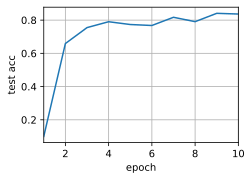

In [50]:
train(num_gpus = 1, batch_size = 256, lr = 0.2)

In [52]:
# 调用两个 GPU 
# train(num_gpus = 2, batch_size = 256, lr = 0.2)
"""
test acc: 0.82, 
2.7 sec/epoch on [device(type='cuda', index=0), 
device(type='cuda', , →index=1)]
"""

In [1]:
# 多 GPU 训练简洁实现
import torch
from torch import nn
from d2l import torch as d2l

In [8]:
# 简单网络
#@save
def resnet18(num_classes, in_channels = 1):
    # 稍加修改的 Resnet-18 模型
    def resnet_block(
        in_channels, out_channels, num_residuals, 
        first_block = False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(
                    d2l.Residual(
                        in_channels, out_channels, 
                        use_1x1conv = True, strides = 2))
            else:
                blk.append(
                    d2l.Residual(
                        out_channels, out_channels))
        return nn.Sequential(*blk)
    # 该模型使用更小的卷积核，删除了最大池化层
    net = nn.Sequential(
        nn.Conv2d(
            in_channels, 64, kernel_size = 3, 
            stride = 1, padding = 1), 
        nn.BatchNorm2d(64), nn.ReLU())
    net.add_module(
        "resnet_block1", 
        resnet_block(64, 64, 2, first_block = True))
    net.add_module("resnet_block2", 
                   resnet_block(64, 128, 2))
    net.add_module("resnet_block3", 
                   resnet_block(128, 256, 2))
    net.add_module("resnet_block4", 
                   resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", 
                   nn.AdaptiveAvgPool2d((1, 1)))
    net.add_module(
        "fc", nn.Sequential(
            nn.Flatten(), nn.Linear(
                512, num_classes)))
    return net

In [9]:
# 网络初始化
net = resnet18(10)
devices = d2l.try_all_gpus()

In [13]:
# 训练
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = load_data_fashion_mnist(
        batch_size)
    devices = [
        d2l.try_gpu(i) 
        for i in range(num_gpus)]
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std = 0.01)
    net.apply(init_weights)
    # 在多个 GPU 上布置模型
    net = nn.DataParallel(
        net, device_ids = devices)
    trainer = torch.optim.SGD(
        net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator(
        "epoch", "test acc", 
        xlim = [1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for x, y in train_iter:
            trainer.zero_grad()
            x, y = x.to(devices[0]), y.to(devices[0])
            l = loss(net(x), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(
            epoch + 1, 
            (d2l.evaluate_accuracy_gpu(
                net, test_iter),))
    print(f"test acc:{animator.Y[0][-1]:.2f}, {timer.avg():.1f}sec/epoch, on{str(devices)}")

test acc:0.92, 99.8sec/epoch, on[device(type='cuda', index=0)]


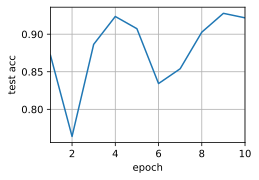

In [14]:
train(net, num_gpus = 1, batch_size = 256, lr = 0.1)

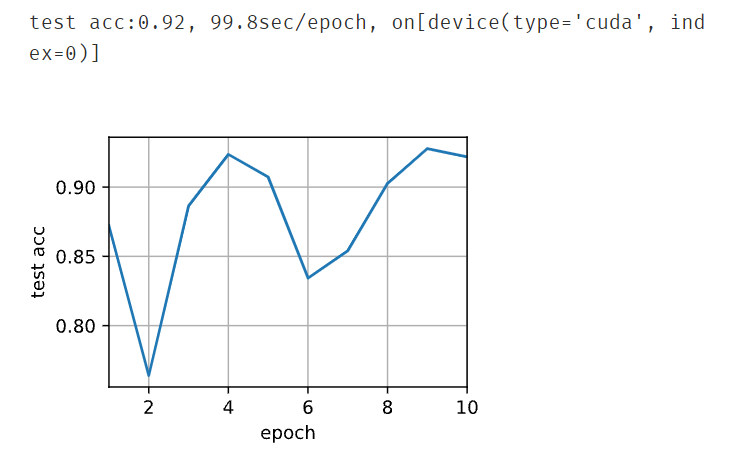